## Imports

In [464]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

import warnings

import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction import text
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier

from sklearn.feature_extraction.text import (CountVectorizer, TfidfVectorizer)

# Table of Contents

1. [Exploratory Data Analysis (EDA)](#Exploratory-Data-Analysis-(EDA))
2. [Count Vectorizer](#Count-Vectorizer)
3. [TFIDF Vectorizer](#TFIDF-Vectorizer)
4. [Vector Hyperparameters with Grid Search](#Vector-Hyperparameters-with-Grid-Search)
5. [Best Model](#Best-model)
6. [Random Forest and Extra Trees](#Random-Forest-and-Extra-Trees)
7. [Data Visualizations](#Data-Visualizations)
8. [Lemmatization*](#Lemmatization)

Notes: * not used in final model, see comments in section for details.

## Exploratory Data Analysis (EDA)

In [465]:
reddit = pd.read_csv('./data/cleaned_selective_data.csv', lineterminator='\n') 
# thank you stack overflow https://stackoverflow.com/questions/33998740/error-in-reading-a-csv-file-in-pandascparsererror-error-tokenizing-data-c-err

In [466]:
reddit['subreddit'].value_counts()

AmItheAsshole     14849
TrueOffMyChest    13570
Name: subreddit, dtype: int64

In [467]:
reddit['subreddit'].value_counts(normalize=True).mul(100).round(2)

AmItheAsshole     52.25
TrueOffMyChest    47.75
Name: subreddit, dtype: float64

In [468]:
reddit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28419 entries, 0 to 28418
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   subreddit    28419 non-null  object
 1   selftext     28417 non-null  object
 2   title        28415 non-null  object
 3   author       28419 non-null  object
 4   score        28419 non-null  int64 
 5   created_utc  28419 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 1.3+ MB


In [469]:
reddit = reddit.dropna() # 6 row difference, I'll drop them for now.

Checking to see if there are any duplicate posts.

In [470]:
reddit[reddit['selftext'].duplicated()]

,subreddit,selftext,title,author,score,created_utc
13,AmItheAsshole,Full disclosure i have been retired since 2017...,spousal problems,lazywaste12,1,1671062622
124,AmItheAsshole,So my M16 little brother M7 has been a ...,for hurting my brother,Afraid-Honey5089,1,1671050695
350,AmItheAsshole,Basically my mother was abusive in my childhoo...,for telling my mom what she did wasnt discipl...,Radiant_Ad_7501,1,1671022234
358,AmItheAsshole,My partner 36F works for her parents floorin...,for questioning whether I should be payed for...,abbielinsey,1,1671020686
362,AmItheAsshole,My BF and I dont live together but he comes ov...,for over feeding my boyfriend,LadyxRadiator,1,1671019800
...,...,...,...,...,...,...
27946,TrueOffMyChest,i wish i was kidding i had to make a throaway ...,my boyfriend broke up with me because i have a...,THROWAWAYbuttfreckle,1,1668564474
27991,TrueOffMyChest,A quick note on pegging This is not going to ...,Im obsessed with pegging guys,lipspa,1,1668557954
28035,TrueOffMyChest,Youd expect some trustworthy form of some sort...,Reddit is a shithole,wholelottaslatttt,1,1668550206
28229,TrueOffMyChest,I wanted to share a story about my relationshi...,My faith saved my relationship,Relative-Flatworm783,1,1668516228


In [471]:
reddit.drop_duplicates(inplace=True)

In [472]:
reddit.shape

(28411, 6)

Instead of dealing with two separate columns, I'll combine all the text in selftext and title into one feature called 'alltext'. Both the title and the body of each post will serve as my X values.

In [473]:
reddit

,subreddit,selftext,title,author,score,created_utc
0,AmItheAsshole,TA Long story short my mom lend my ski Jacket...,for being upset bc my mom lend my ski gear wi...,Euphoric_Ad9171,1,1671064095
1,AmItheAsshole,Rachel Katy and I were part of a big friend gr...,for not inviting my friend to a concert she c...,JLA_turtles,1,1671064032
2,AmItheAsshole,So me 17 and my mom 36 are in a fight and I ne...,for telling my mom I wont talk to her again i...,throwaway291723,1,1671064025
3,AmItheAsshole,I 21f got a new roomate Mary 23f this year ...,for ignoring my roommate,Zealousideal-Big-358,1,1671063969
4,AmItheAsshole,a couple months ago me 18 F and my ex boyfri...,for sending nudes to my ex boyfriends best fr...,breezyrenae23,1,1671063907
...,...,...,...,...,...,...
28414,TrueOffMyChest,My fiance is a grad student that teaches and I...,Feel guilty for not being able to make my fian...,oldschoolsadness,1,1668472925
28415,TrueOffMyChest,I have a 12 year old son with autism And a 8 y...,My kids fight over food and eating foods that ...,SavannahLion341,1,1668472845
28416,TrueOffMyChest,I 15M am sad all the time I never go outside...,If people really knew,Significant-Act-712,1,1668472608
28417,TrueOffMyChest,Im currently dating a guy We both love each ot...,I still miss my ex even though i have a new bo...,Sea_Freedom_612,1,1668472542


In [474]:
reddit['alltext'] = reddit['title'] + " " + reddit['selftext'] 

In [475]:
reddit.head(3)

,subreddit,selftext,title,author,score,created_utc,alltext
0,AmItheAsshole,TA Long story short my mom lend my ski Jacket...,for being upset bc my mom lend my ski gear wi...,Euphoric_Ad9171,1,1671064095,for being upset bc my mom lend my ski gear wi...
1,AmItheAsshole,Rachel Katy and I were part of a big friend gr...,for not inviting my friend to a concert she c...,JLA_turtles,1,1671064032,for not inviting my friend to a concert she c...
2,AmItheAsshole,So me 17 and my mom 36 are in a fight and I ne...,for telling my mom I wont talk to her again i...,throwaway291723,1,1671064025,for telling my mom I wont talk to her again i...


In [476]:
reddit['alltext'].str.contains('http').sum()

91

91 out of 28,000 rows with a hyperlink isn't a particularly high percentage. I won't remove any of them, after the cleaning the URL would be broken up into it's components, which may grant some meaningful insight.

There may be some insight to which subreddit a post belongs if there's a trend in the total length.

In [477]:
reddit['text_length'] = reddit['alltext'].str.len()

In [478]:
reddit.head(3)

,subreddit,selftext,title,author,score,created_utc,alltext,text_length
0,AmItheAsshole,TA Long story short my mom lend my ski Jacket...,for being upset bc my mom lend my ski gear wi...,Euphoric_Ad9171,1,1671064095,for being upset bc my mom lend my ski gear wi...,764
1,AmItheAsshole,Rachel Katy and I were part of a big friend gr...,for not inviting my friend to a concert she c...,JLA_turtles,1,1671064032,for not inviting my friend to a concert she c...,2927
2,AmItheAsshole,So me 17 and my mom 36 are in a fight and I ne...,for telling my mom I wont talk to her again i...,throwaway291723,1,1671064025,for telling my mom I wont talk to her again i...,878


In [479]:
reddit['word_count'] = reddit['alltext'].apply(lambda x: len(x.split()))

In [480]:
reddit.head(3)

,subreddit,selftext,title,author,score,created_utc,alltext,text_length,word_count
0,AmItheAsshole,TA Long story short my mom lend my ski Jacket...,for being upset bc my mom lend my ski gear wi...,Euphoric_Ad9171,1,1671064095,for being upset bc my mom lend my ski gear wi...,764,168
1,AmItheAsshole,Rachel Katy and I were part of a big friend gr...,for not inviting my friend to a concert she c...,JLA_turtles,1,1671064032,for not inviting my friend to a concert she c...,2927,578
2,AmItheAsshole,So me 17 and my mom 36 are in a fight and I ne...,for telling my mom I wont talk to her again i...,throwaway291723,1,1671064025,for telling my mom I wont talk to her again i...,878,199


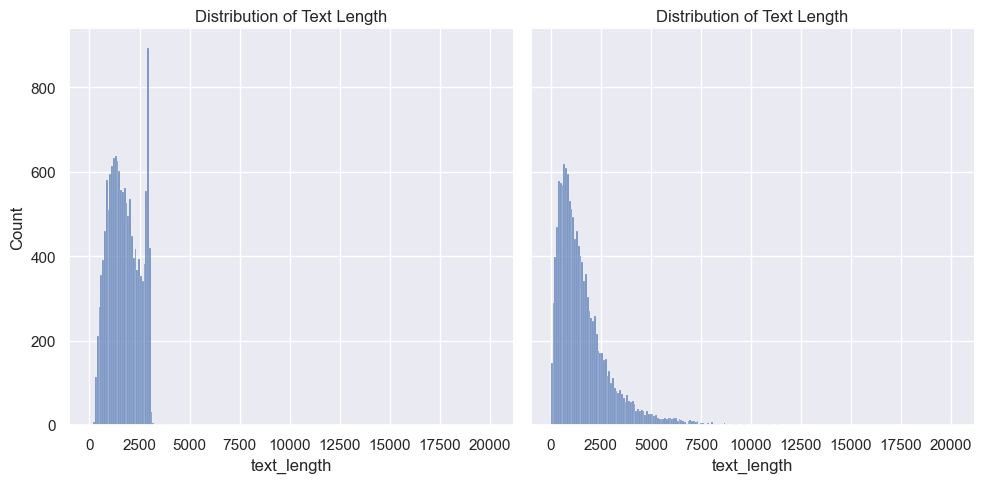

In [481]:
sns.displot(data = reddit,
            x = 'text_length',
            col = 'subreddit').set(title = 'Distribution of Text Length')

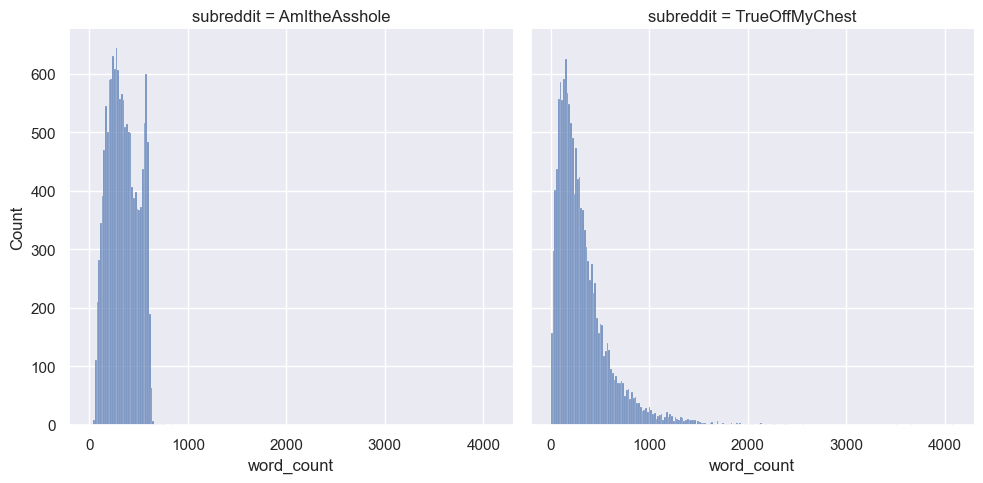

In [482]:
sns.displot(data = reddit,
           x = 'word_count',
           col = 'subreddit')

The distributions for text length and word count are very much right skewed but something odd appears in AITA where there's a sudden surge in both.

In [483]:
reddit['alltext']\
[(reddit['word_count'] > 400) &\
(reddit['text_length'] > 400) *\
(reddit['subreddit'] == 'AmItheAsshole')][1]

' for not inviting my friend to a concert she couldnt even go to Rachel Katy and I were part of a big friend group  about 13 people  but the three of us grew really close over the years \xa0 The issue started when we made plans on the weekend to hang out with everyone  for context Rachel has very strict parents and because of her religious group she cant go out on Friday nights since her family always has dinner with said group that day  So as I mentioned before we are a really big friend group and it is hard to make plans for everyone to go and our solution is usually to go out on the day most people can  for example if 7 people can go out on Friday and only 4 on Saturday we make plans on Friday so most of us can be there   \xa0 Rachel would get really mad when this happened because she felt we were doing it on purpose so she wasnt there  we were not   Because of this she would leave the group chat and expected everyone to comfort her and accommodate the plan on a day she could be the

In [484]:
reddit['alltext'] = reddit['alltext'].str.replace(u'\xa0', ' ')

In [485]:
reddit['selftext'] = reddit['selftext'].str.replace(u'\xa0', ' ')

In [486]:
reddit['alltext']\
[(reddit['word_count'] > 400) &\
(reddit['text_length'] > 400) *\
(reddit['subreddit'] == 'AmItheAsshole')][1]

' for not inviting my friend to a concert she couldnt even go to Rachel Katy and I were part of a big friend group  about 13 people  but the three of us grew really close over the years   The issue started when we made plans on the weekend to hang out with everyone  for context Rachel has very strict parents and because of her religious group she cant go out on Friday nights since her family always has dinner with said group that day  So as I mentioned before we are a really big friend group and it is hard to make plans for everyone to go and our solution is usually to go out on the day most people can  for example if 7 people can go out on Friday and only 4 on Saturday we make plans on Friday so most of us can be there     Rachel would get really mad when this happened because she felt we were doing it on purpose so she wasnt there  we were not   Because of this she would leave the group chat and expected everyone to comfort her and accommodate the plan on a day she could be there   n

The word 'subreddit' appears a few times in bodies of the text. If I leave my column as is, I'll have duplicated columns later. 

In [487]:
reddit.rename(columns = ({'subreddit':'SUB_RED_IT'}), inplace = True)

In [488]:
reddit.head(3)

,SUB_RED_IT,selftext,title,author,score,created_utc,alltext,text_length,word_count
0,AmItheAsshole,TA Long story short my mom lend my ski Jacket...,for being upset bc my mom lend my ski gear wi...,Euphoric_Ad9171,1,1671064095,for being upset bc my mom lend my ski gear wi...,764,168
1,AmItheAsshole,Rachel Katy and I were part of a big friend gr...,for not inviting my friend to a concert she c...,JLA_turtles,1,1671064032,for not inviting my friend to a concert she c...,2927,578
2,AmItheAsshole,So me 17 and my mom 36 are in a fight and I ne...,for telling my mom I wont talk to her again i...,throwaway291723,1,1671064025,for telling my mom I wont talk to her again i...,878,199


## Count Vectorizer

In [489]:
X = reddit['alltext']
y = reddit['SUB_RED_IT']

In [490]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [491]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape # sanity check

((21308,), (7103,), (21308,), (7103,))

In [492]:
print(y_train.value_counts(normalize=True))
print(y_test.value_counts(normalize=True)) # more sanity checks

AmItheAsshole     0.522621
TrueOffMyChest    0.477379
Name: SUB_RED_IT, dtype: float64
AmItheAsshole     0.522596
TrueOffMyChest    0.477404
Name: SUB_RED_IT, dtype: float64


In [493]:
pipe = Pipeline([
    ('cv', CountVectorizer()), # transformer
    ('logreg', LogisticRegression(random_state=42, max_iter=10_000)) # estimator
])

In [494]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('cv', CountVectorizer()),
                ('logreg',
                 LogisticRegression(max_iter=10000, random_state=42))])

In [495]:
pipe.score(X_train, y_train), pipe.score(X_test, y_test)

(0.9980758400600713, 0.8786428269745178)

Overfit as expected with a dry CountVec run. Let's see if TFIDF fairs any differently.

In [496]:
results = pd.DataFrame(columns = ['Model', 'Train', 'Test'])

In [497]:
# results = results.append({'Model': 'CV/LogReg', 'Train': pipe.score(X_train, y_train), 'Test': pipe.score(X_test, y_test)}, ignore_index=True)
# append method deprecated. Using alternative.

results.loc[len(results.index)] = ['CV/LogReg', pipe.score(X_train, y_train), pipe.score(X_test, y_test)]

In [498]:
results

,Model,Train,Test
0,CV/LogReg,0.998076,0.878643


## TFIDF Vectorizer

In [499]:
tfidf = TfidfVectorizer(stop_words='english')

In [500]:
tfidf_pipe = Pipeline([
    ('tfidf', tfidf),
    ('logreg', LogisticRegression(random_state=42, max_iter=10_000))
])

In [501]:
tfidf_pipe.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer(stop_words='english')),
                ('logreg',
                 LogisticRegression(max_iter=10000, random_state=42))])

In [502]:
tfidf_pipe.score(X_train, y_train), tfidf_pipe.score(X_test, y_test)

(0.9171672611225831, 0.8738561171336056)

Even though the test set is slightly lower than the count vectorizer, it's about 6% less overfit. I'd use this model if I had nothing else.

I'm going to avoid lemmatizing the text because contextual language is quite informative in a subreddit as subjective as these highly opinionated story telling subreddits. I want to keep that context that gets lost by lemmatization.

On another note, running KNN on a dataset this large led high computation time and resource use. Since KNearestNeighbors is very resource intensive for a larger datasets and I will refrain from running it. 86.5% accuracy on the test set is good enough at the moment and I don't think the potential of getting a couple percent better with KNN is worth it. 

In [503]:
results.loc[len(results.index)] = ['TFIDF/LogReg', tfidf_pipe.score(X_train, y_train), tfidf_pipe.score(X_test, y_test)]
results

,Model,Train,Test
0,CV/LogReg,0.998076,0.878643
1,TFIDF/LogReg,0.917167,0.873856


## Vector Hyperparameters with Grid Search

Let's see if I can get some better performance out of a Grid Search optimized TFID.

In [504]:
# redefining variables just in case
X = reddit['alltext']
y = reddit['SUB_RED_IT']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [505]:
pipe = Pipeline([
    ('tfidf', tfidf),
    ('logreg', LogisticRegression(random_state=42, max_iter=10_000))
])

In [506]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer(stop_words='english')),
                ('logreg',
                 LogisticRegression(max_iter=10000, random_state=42))])

In [507]:
gs = GridSearchCV(pipe, param_grid={
    'tfidf__stop_words':['english'],
    'tfidf__ngram_range': [(1,1),(2,2)], # i run out of memory when running (1,2)
    'logreg__fit_intercept': [True, False],
    'logreg__max_iter': [100, 500],
    'logreg__C': [0.1, 1, 10]
    }, cv=5, verbose=1)

In [508]:
# with warnings.catch_warnings():
#     warnings.simplefilter("ignore") # supressing warnings for nonconvergence. 
#     gs.fit(X_train, y_train)

In [509]:
# gs.best_params_ # commenting best params here to save time when rerunning notebook for debugging.
# {'logreg__C': 10,
#  'logreg__fit_intercept': True,
#  'logreg__max_iter': 100,
#  'tfidf__ngram_range': (1, 1),
#  'tfidf__stop_words': 'english'}

In [510]:
tfidf = TfidfVectorizer(stop_words='english')
logreg = LogisticRegression() #Altering the C value only made the model more overfit. 

In [511]:
pipe = Pipeline([
    ('tfidf', tfidf),
    ('logreg', logreg)
])

In [512]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer(stop_words='english')),
                ('logreg', LogisticRegression())])

## Best model

In [513]:
# C=10 had train score of 99.3 and a test score 87.5. The marginal increase in the test score is not worth the overfitting.
pipe.score(X_train, y_train), pipe.score(X_test, y_test)

(0.9171672611225831, 0.8738561171336056)

Score to beat is 52.25% AITA (negative or 0 in this case), 47.75% TOMC (positive or 1). 87.36% being quite a bit better than our baseline score.

In [514]:
with open('./model/AITA.pkl', 'wb') as f:
    pickle.dump(pipe, f)

In [515]:
results.loc[len(results.index)] = ['LogReg', pipe.score(X_train, y_train), pipe.score(X_test, y_test)]
results

,Model,Train,Test
0,CV/LogReg,0.998076,0.878643
1,TFIDF/LogReg,0.917167,0.873856
2,LogReg,0.917167,0.873856


In [516]:
tfidf.fit(X_train)

Xx_train = tfidf.transform(X_train)
Xx_test = tfidf.transform(X_test)

In [517]:
df = pd.DataFrame(Xx_train.todense(), columns = tfidf.get_feature_names_out()) # will be used in data visualizations.

In [518]:
preds = pipe.predict(X_test)

In [519]:
# sns.set(font_scale = 1.5)
# df.sum().sort_values(ascending=False).head(15).plot(kind='barh')

## Random Forest and Extra Trees

In [520]:
X = reddit['alltext']
y = reddit['SUB_RED_IT']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [521]:
rfc = RandomForestClassifier(random_state=42)
etc = ExtraTreesClassifier(random_state=42)

In [522]:
tfidf.fit(X_train)

Xtf_train = tfidf.transform(X_train)
Xtf_test = tfidf.transform(X_test)

In [523]:
params = {
    'n_estimators': [100, 200, 300],
    'max_depth' : [3, 5, 10],
    'min_samples_leaf' : [3, 5, 10],
    'min_samples_split' : [5, 10, 15, 20]
}

In [524]:
# gs = GridSearchCV(estimator=rfc, param_grid = params, n_jobs=-1, cv=5)

In [525]:
# gs.fit(Xtf_train, y_train) commenting out to save on compute when rerunning notebook.

In [526]:
# gs.best_params_
# commenting best params here. save on notebook computation while I rerun and debug other parts.
# {'max_depth': 10,
#  'min_samples_leaf': 3,
#  'min_samples_split': 20,
#  'n_estimators': 200}

In [527]:
gs = GridSearchCV(estimator=etc, param_grid = params, n_jobs=-1, cv=5)

In [528]:
# gs.fit(Xtf_train, y_train)

In [529]:
# gs.best_params_
# {'max_depth': 10,
#  'min_samples_leaf': 3,
#  'min_samples_split': 15,
#  'n_estimators': 100}

In [530]:
rfc = RandomForestClassifier(n_estimators=200, max_depth= 10, min_samples_leaf=3, min_samples_split=20, random_state=42, n_jobs=-1)
etc = ExtraTreesClassifier(n_estimators=100, max_depth= 10, min_samples_leaf=3, min_samples_split=15, random_state=42, n_jobs=-1)

In [531]:
rfc.fit(Xtf_train, y_train.values.ravel())
etc.fit(Xtf_train, y_train.values.ravel())

ExtraTreesClassifier(max_depth=10, min_samples_leaf=3, min_samples_split=15,
                     n_jobs=-1, random_state=42)

In [532]:
results.loc[len(results.index)] = ['Random Forest', rfc.score(Xtf_train, y_train), rfc.score(Xtf_test, y_test)]
results.loc[len(results.index)] = ['Extra Trees', etc.score(Xtf_train, y_train), etc.score(Xtf_test, y_test)]

results

,Model,Train,Test
0,CV/LogReg,0.998076,0.878643
1,TFIDF/LogReg,0.917167,0.873856
2,LogReg,0.917167,0.873856
3,Random Forest,0.863572,0.836407
4,Extra Trees,0.703679,0.686471


I'll have to stick to the logistic regression model here.

## Data Visualizations

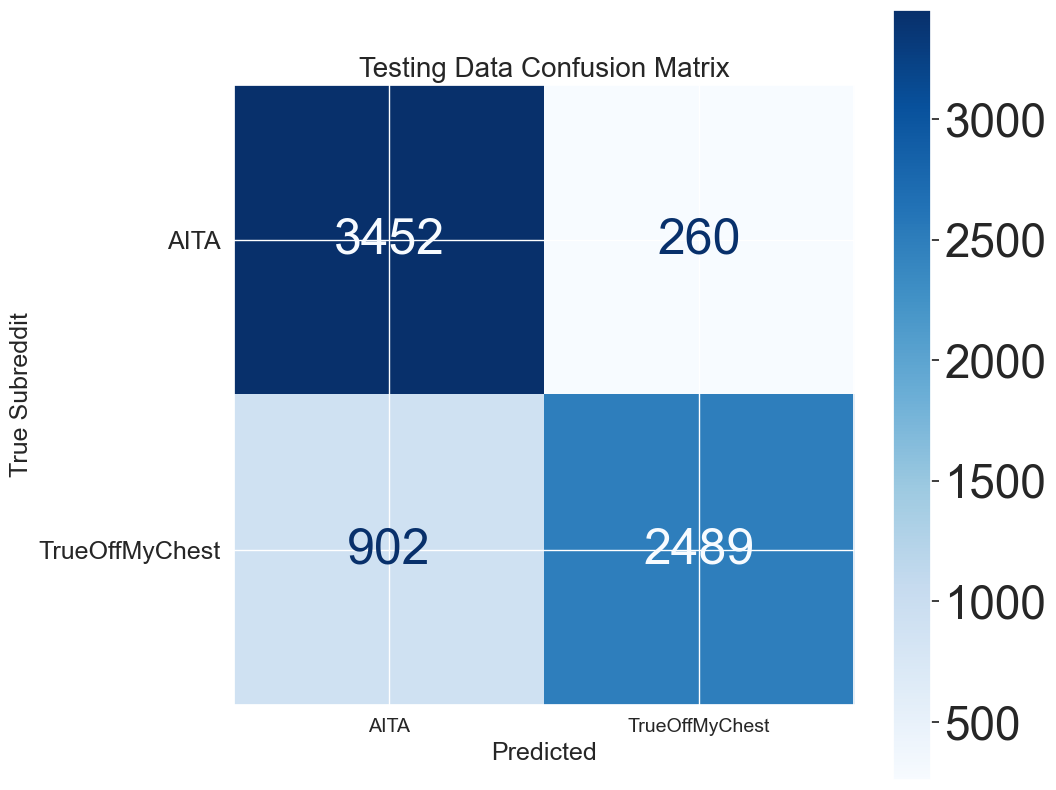

In [533]:
fig, ax = plt.subplots(figsize=(10, 10)) # generating a larger image to downscale later for presentation purposes
# setting large font scale for readability. 
# Unable to remove the white space in the boxes
sns.set(font_scale = 3.0)

ConfusionMatrixDisplay.from_estimator(rfc, Xtf_test, y_test, cmap="Blues", ax=ax)

ax.set_title('Testing Data Confusion Matrix', fontsize=20)
ax.set_xlabel('Predicted', fontsize=18)
ax.set_xticklabels(labels=['AITA', 'TrueOffMyChest'], fontsize=14)
ax.set_ylabel('True Subreddit', fontsize=18)
ax.set_yticklabels(labels=['AITA', 'TrueOffMyChest'], fontsize=18)

plt.show()

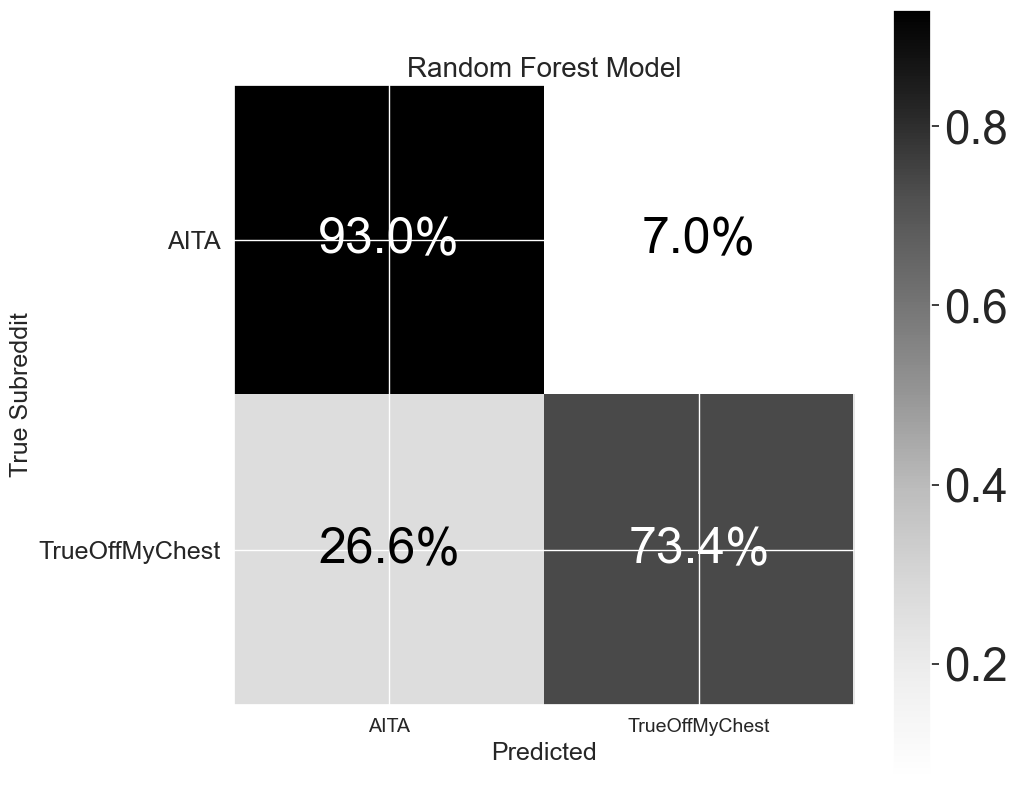

In [534]:
fig, ax = plt.subplots(figsize=(10, 10))

sns.set(font_scale = 3.0)

ConfusionMatrixDisplay.from_estimator(rfc, 
                                      Xtf_test, 
                                      y_test, 
                                      cmap="Greys", 
                                      ax=ax, 
                                      normalize='true',
                                      values_format='.1%')

ax.set_title('Random Forest Model', fontsize=20)
ax.set_xlabel('Predicted', fontsize=18)
ax.set_xticklabels(labels=['AITA', 'TrueOffMyChest'], fontsize=14)
ax.set_ylabel('True Subreddit', fontsize=18)
ax.set_yticklabels(labels=['AITA', 'TrueOffMyChest'], fontsize=18)

plt.show()

My random forest model is disproportionately predicting AITA over TOMC. This model has an inherent bias to predict in favor of AITA. The model is not as good as I would like it to be in this regard. Shifting my attention back to my final LogReg model:

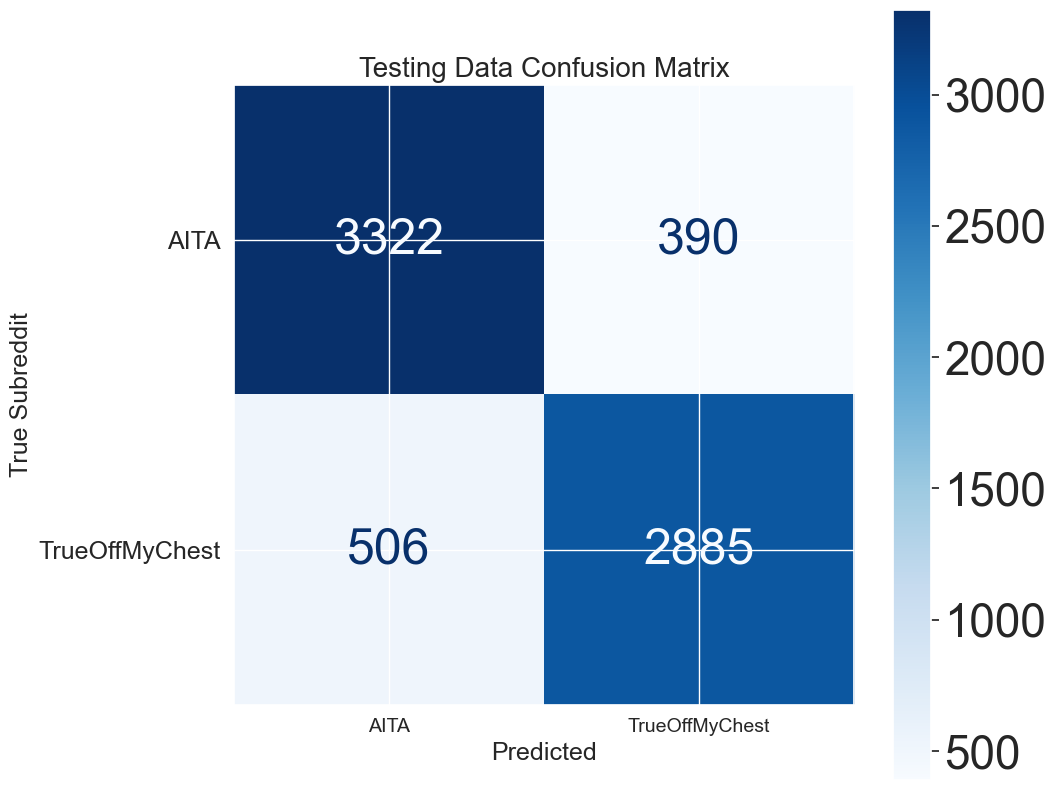

In [535]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.set(font_scale = 3.0)

ConfusionMatrixDisplay.from_estimator(pipe, X_test, y_test, cmap="Blues", ax=ax)

ax.set_title('Testing Data Confusion Matrix', fontsize=20)
ax.set_xlabel('Predicted', fontsize=18)
ax.set_xticklabels(labels=['AITA', 'TrueOffMyChest'], fontsize=14)
ax.set_ylabel('True Subreddit', fontsize=18)
ax.set_yticklabels(labels=['AITA', 'TrueOffMyChest'], fontsize=18)

plt.show()

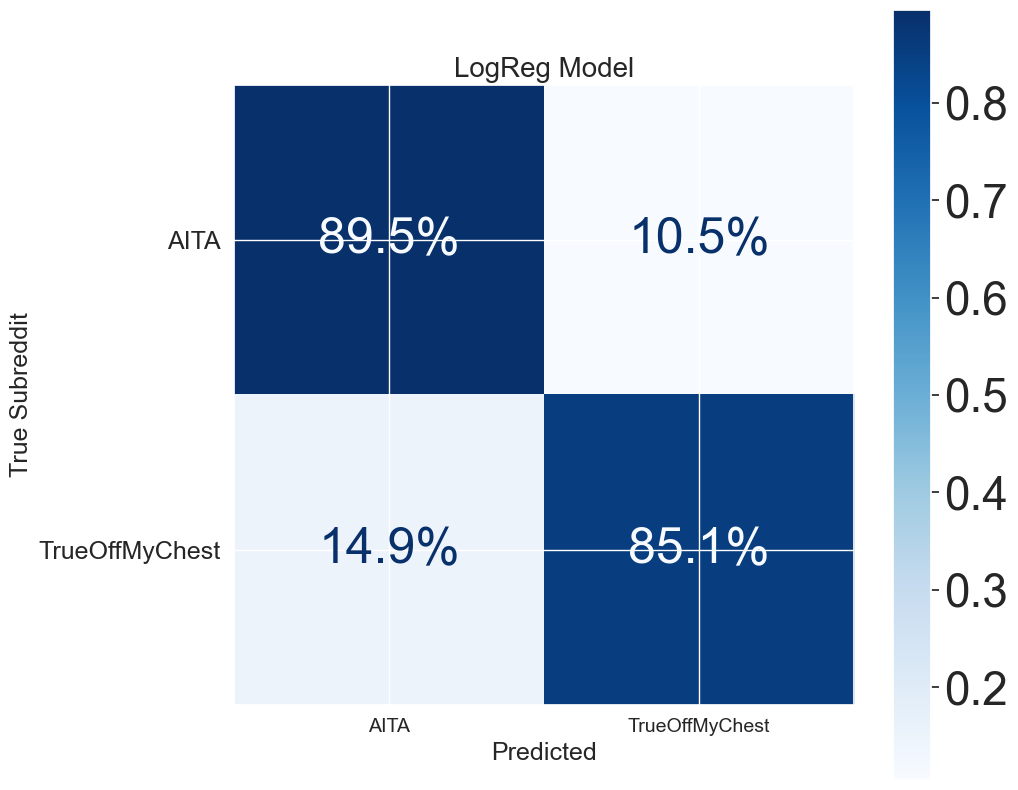

In [536]:
fig, ax = plt.subplots(figsize=(10, 10))

sns.set(font_scale = 3.0)

ConfusionMatrixDisplay.from_estimator(pipe, 
                                      X_test, 
                                      y_test, 
                                      cmap="Blues", 
                                      ax=ax, 
                                      normalize='true',
                                      values_format='.1%')

ax.set_title('LogReg Model', fontsize=20)
ax.set_xlabel('Predicted', fontsize=18)
ax.set_xticklabels(labels=['AITA', 'TrueOffMyChest'], fontsize=14)
ax.set_ylabel('True Subreddit', fontsize=18)
ax.set_yticklabels(labels=['AITA', 'TrueOffMyChest'], fontsize=18)

plt.show()

In [537]:
text = "It was I who languised for years thinking of nothing but you,\
    but for this moment, and now the perfect tool for my vengence is\
    in front of us. I never planned on killing you but I will make you\
    share my pain, Kenobi"
pipe.predict([text])[0]

'TrueOffMyChest'

In [538]:
text = "Justice is merely the construct of the current power base. A base which, according to my calculations, is about to change!"
pipe.predict([text])[0]

'AmItheAsshole'

In [539]:
all_pred = pipe.predict(reddit['alltext'])

The percentages here is pretty useful. Despite having a lower overall accuracy in terms of raw number, I would argue the LogReg model performs better than the Random Forest. There is significantly less bias in this model as the predictions are more evenly split between the two subreddits. With an initial spread of 52% and 47% AITA vs TOMC, I expected a slight bias towards AITA, which is the case here. That bias becomes significantly heavier in the Random Forest model. Thus the best model for my purpose is LogReg. 

In [540]:
reddit['predictions'] = all_pred

In [541]:
#false TrueOffMyChest (positive):
reddit[['selftext', 'title']][(reddit['SUB_RED_IT'] == 'AmItheAsshole')\
                              & (reddit['predictions'] == 'TrueOffMyChest')].iloc[2,0]

'My wife and I are at ends with this shes convinced gentle parenting is the only appropriate way to parent a child While I conform to her preferences I still believe as the father I reserve the right to be able to discipline in other ways when her method isnt working While I respect her wishes and make the attempts I dont believe shes right to tell me that I cant spank my child and threaten with ultimatums either  For context I was hit as a kid frankly quite a bit at times She wasnt My father was also verbally and emotionally abusive so Im well aware with what abuse looks like For that reason Ive done a lot of work on myself to not repeat those patterns I very seldom spank my kids and when I do its an open hand swat on their bum or their hand However every time that happens am an abusive parent continuing the vicious cycle from my childhood I dont feel thats fair nor accurate '

In [542]:
# false AITA(negative):
reddit[['selftext', 'title']][(reddit['SUB_RED_IT'] == 'TrueOffMyChest')\
                              & (reddit['predictions'] == 'AmItheAsshole')].iloc[19, 0]

'   For some background I  33F  have been with my BF  27M  for 2 years I was in an emotionally abusive relationship for 6 years before I started dating my current BF and it affected my son 13M  more than I realized I also have a 6 year old daughter with my previous BF My sons dad also has been in and out of his life since he was a baby He moved out of state at the beginning of summer and rarely talks to my son now I have asked him if it was possible for him to move back her to help me with his son and he said he would after he heard everything that has happened recently But he has since gone no contact for a few weeks now so who knows whats going on with him  My current BF loves my kids but I know for a fact that my daughter is his favorite The problem is that he gets mad at my son for every little thing that he does It started about a year and a half ago My son has made some really really bad choices He has burnt dryer lint in the basement and set the carpet on fire We are currently r

In the context of telling a story to evaluate whether someone is being an a-hole or a story to get off your chest, using language referring to yourself like I'm (transformed to 'im') can be informative. Words like "really" lemmatized to "real" would remove too much context. In this case, I will not lemmatize strictly because I want emphasis and context in the story telling contained in the posts.  But for the sake of argument, I will explore some [lemmatization](#Lemmatization) below. 

In [543]:
# True AITA (true negative):
reddit[['selftext', 'title']][(reddit['SUB_RED_IT'] == 'AmItheAsshole')\
                              & (reddit['predictions'] == 'AmItheAsshole')].iloc[0, 0]

'TA  Long story short my mom lend my ski Jacket to a family friends kid I  25m  life in a different city to study and dont have that much space where I life so I store my gear in their house Last weekend I visited home to collect my stuff bc Im going skiing myself I was confused bc I couldnt find my ski Jacket When I asked where it is I got told that the kid has it Obviously I was pretty upset but my mom cant understand why Even if I didnt go skiing I would not have given it to him Its sports wear and you sweat quite a bit and I find this gross af Shes arguing its a good thing so he has not to by one and I can lend one from my dad I kind of gave her a hard time about it and now i feel guilty  here'

In [544]:
# True TOMC (true positive):
reddit[['selftext', 'title']][(reddit['SUB_RED_IT'] == 'TrueOffMyChest')\
                              & (reddit['predictions'] == 'TrueOffMyChest')].iloc[5, 0]

'I am a high school teacher and while I do love my job Ive been doing it for over 3 decades and Im tired Today one of my seniors who has become quite conceited as the result of winning a prestigious academic award was really nasty to me and tried to pass it off as a joke Im so ready to retire but financially I need to wait a few more years It was just a cruddy day Thanks for listening'

In [545]:
words = df.sum().sort_values(ascending=False)

In [546]:
words_df = pd.DataFrame(words)

In [547]:
words_df.reset_index(inplace=True)

In [548]:
words_df.rename(columns = {'index':'word', 0:'count'}, inplace = True)

In [549]:
words_df.sort_values(by = 'count', ascending=False)[:11]

,word,count
0,im,920.553923
1,just,796.897889
2,like,706.259824
3,dont,673.838141
4,know,540.861440
5,said,537.652947
6,feel,530.605750
7,told,525.226584
8,time,525.089454
9,want,508.002120


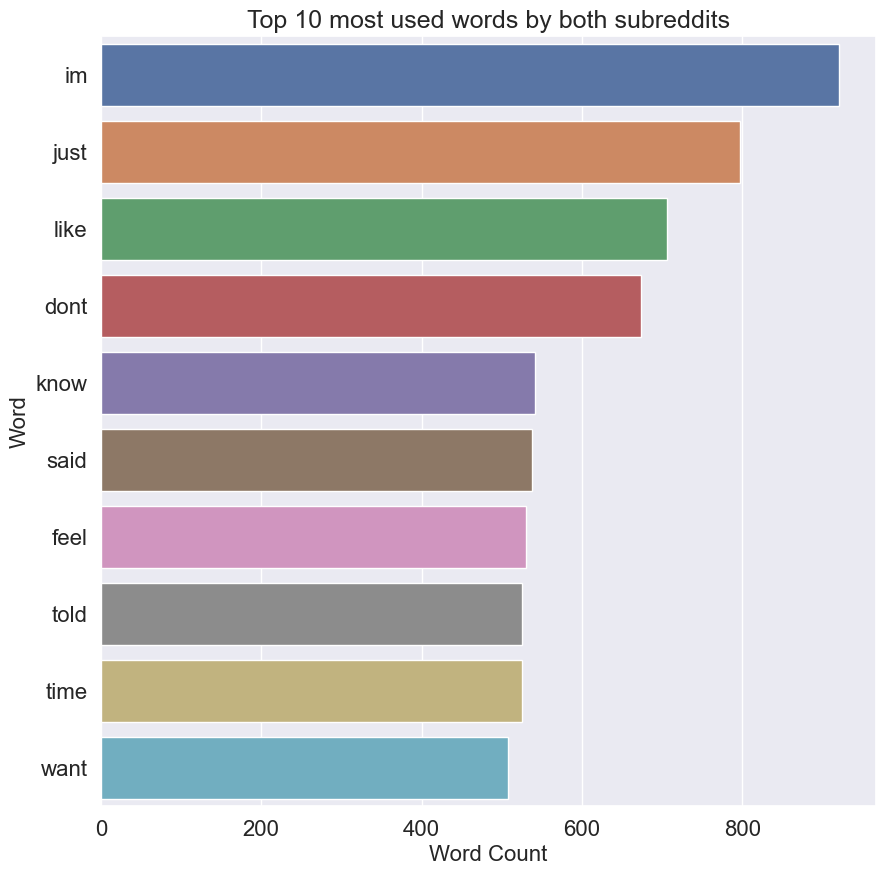

In [550]:
plt.figure(figsize=(10,10))
sns.set(font_scale = 1)
sns.barplot(data = words_df.sort_values(by = 'count', ascending=False)[:10], 
            y = 'word', 
            x = 'count').set(title = "Top 10 most used words by both subreddits")

plt.title('Top 10 most used words by both subreddits', fontsize = 18)
plt.xlabel('Word Count', fontsize=16);
plt.ylabel('Word', fontsize=16);
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

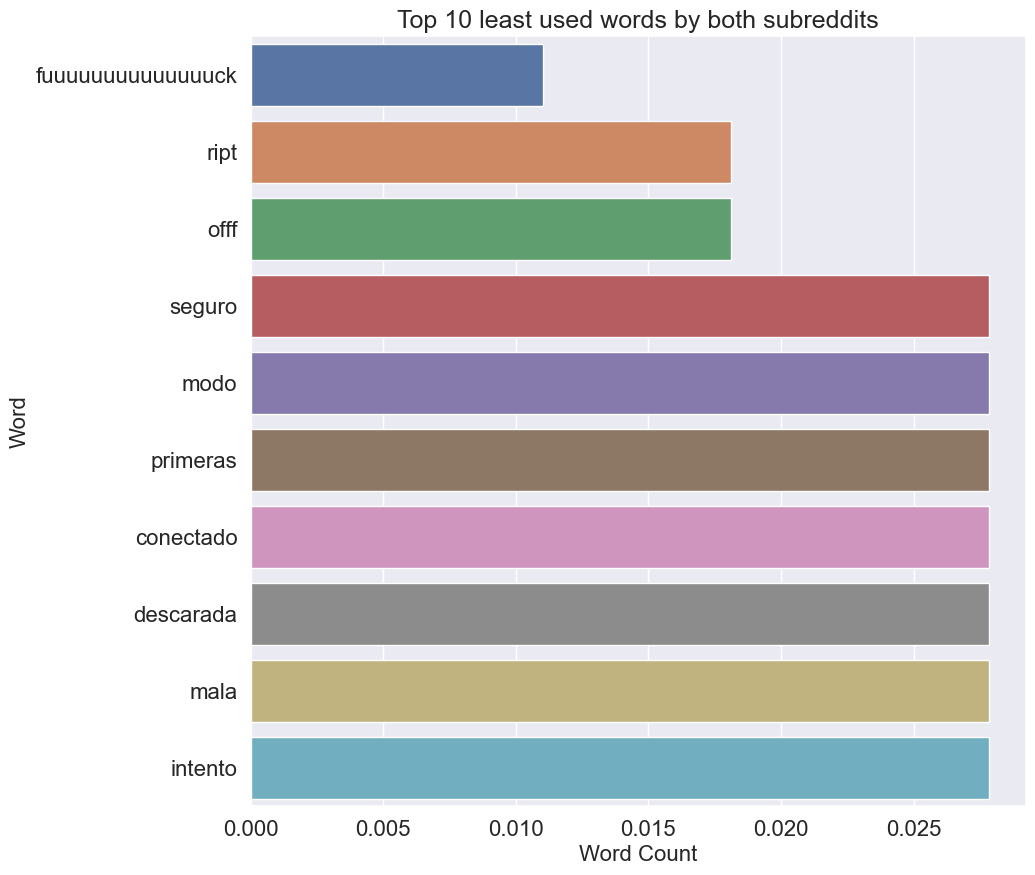

In [551]:
plt.figure(figsize=(10,10))

ax = sns.barplot(data = words_df.sort_values(by = 'count', ascending=True)[:10], 
            y = 'word', 
            x = 'count')

plt.title('Top 10 least used words by both subreddits', fontsize = 18)
plt.xlabel('Word Count', fontsize=16);
plt.ylabel('Word', fontsize=16);
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.show()

In [552]:
df['SUB_RED_IT'] = reddit["SUB_RED_IT"]

In [553]:
TOMCwords = df[(df['SUB_RED_IT'] != "AmItheAsshole")].sum().sort_values(ascending=False)

/var/folders/2f/m4z0nfhn5px0p2mdppmmrlxr0000gn/T/ipykernel_6662/3575965067.py:1: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  TOMCwords = df[(df['SUB_RED_IT'] != "AmItheAsshole")].sum().sort_values(ascending=False)


In [554]:
AITAwords = df[(df['SUB_RED_IT'] != "TrueOffMyChest")].sum().sort_values(ascending=False)

/var/folders/2f/m4z0nfhn5px0p2mdppmmrlxr0000gn/T/ipykernel_6662/2745797755.py:1: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  AITAwords = df[(df['SUB_RED_IT'] != "TrueOffMyChest")].sum().sort_values(ascending=False)


In [555]:
TOMCword_df = pd.DataFrame(TOMCwords)
AITAword_df = pd.DataFrame(AITAwords)

TOMCword_df.reset_index(inplace=True)
AITAword_df.reset_index(inplace=True)

TOMCword_df.rename(columns = {'index': 'word', 0: 'count'}, inplace = True)
AITAword_df.rename(columns = {'index': 'word', 0: 'count'}, inplace = True)

In [556]:
TOMCword_df = TOMCword_df[(TOMCword_df['count']>0)]
AITAword_df = AITAword_df[(AITAword_df['count']>0)]

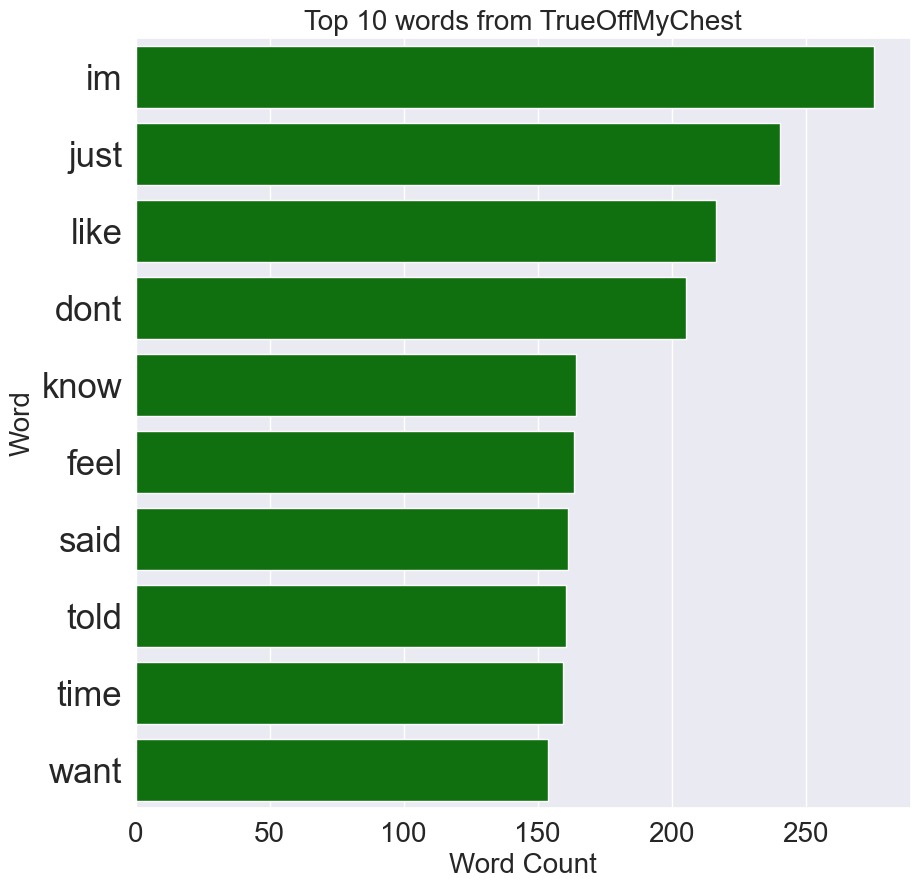

In [557]:
plt.figure(figsize = (10,10))

sns.barplot(data = TOMCword_df.sort_values(by = 'count', ascending=False)[:10], 
            y = 'word', 
            x = 'count',
            color = "Green")

plt.title("Top 10 words from TrueOffMyChest", fontsize=20)
plt.xlabel('Word Count', fontsize=20);
plt.ylabel('Word', fontsize=20);
plt.xticks(fontsize=20)
plt.yticks(fontsize=25)
plt.show()

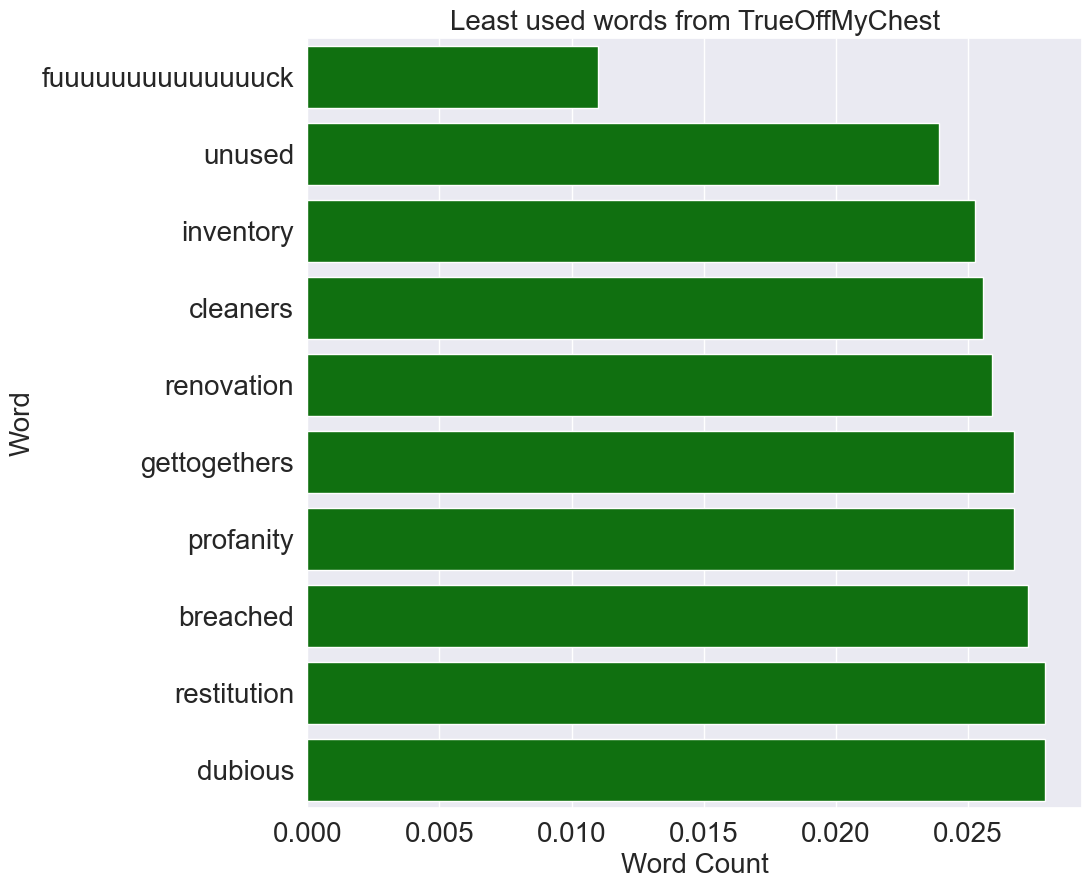

In [558]:
plt.figure(figsize = (10,10))

sns.barplot(data = TOMCword_df.sort_values(by = 'count', ascending=True)[:10], 
            y = 'word', 
            x = 'count',
            color = "Green")

plt.title("Least used words from TrueOffMyChest", fontsize=20)
plt.xlabel('Word Count', fontsize=20);
plt.ylabel('Word', fontsize=20);
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

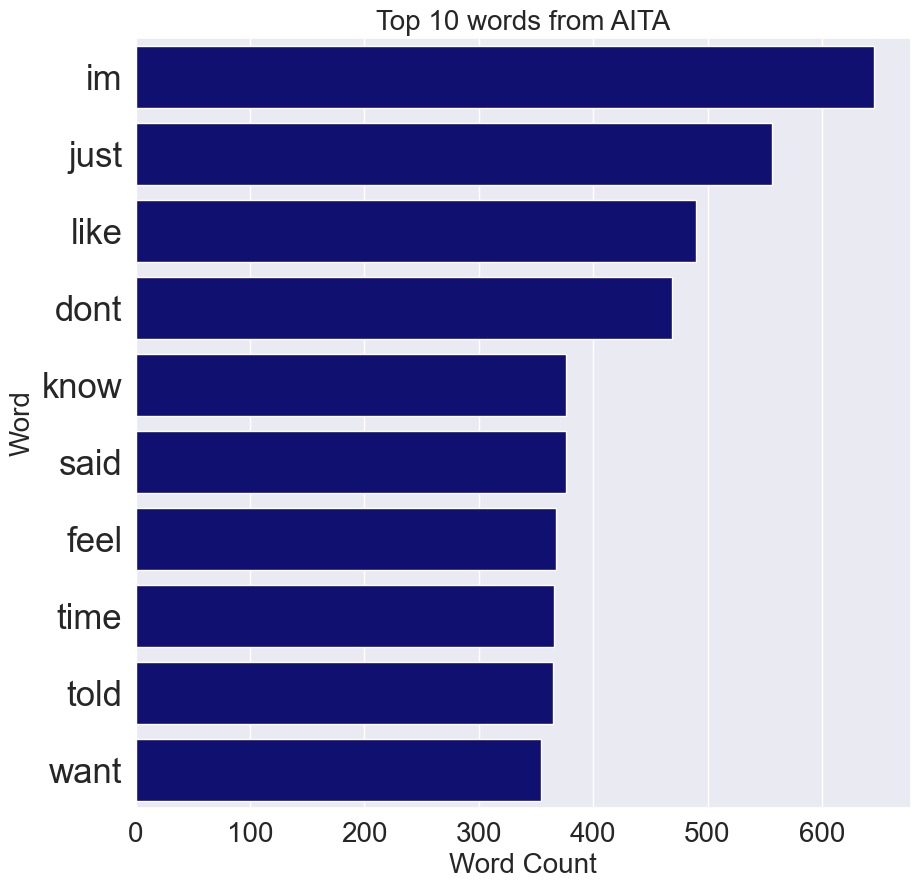

In [559]:
plt.figure(figsize = (10,10))

sns.barplot(data = AITAword_df.sort_values(by = 'count', ascending=False)[:10], 
            y = 'word', 
            x = 'count',
            color = 'Navy')

plt.title("Top 10 words from AITA", fontsize=20)
plt.xlabel('Word Count', fontsize=20);
plt.ylabel('Word', fontsize=20);
plt.xticks(fontsize=20)
plt.yticks(fontsize=25)
plt.show()

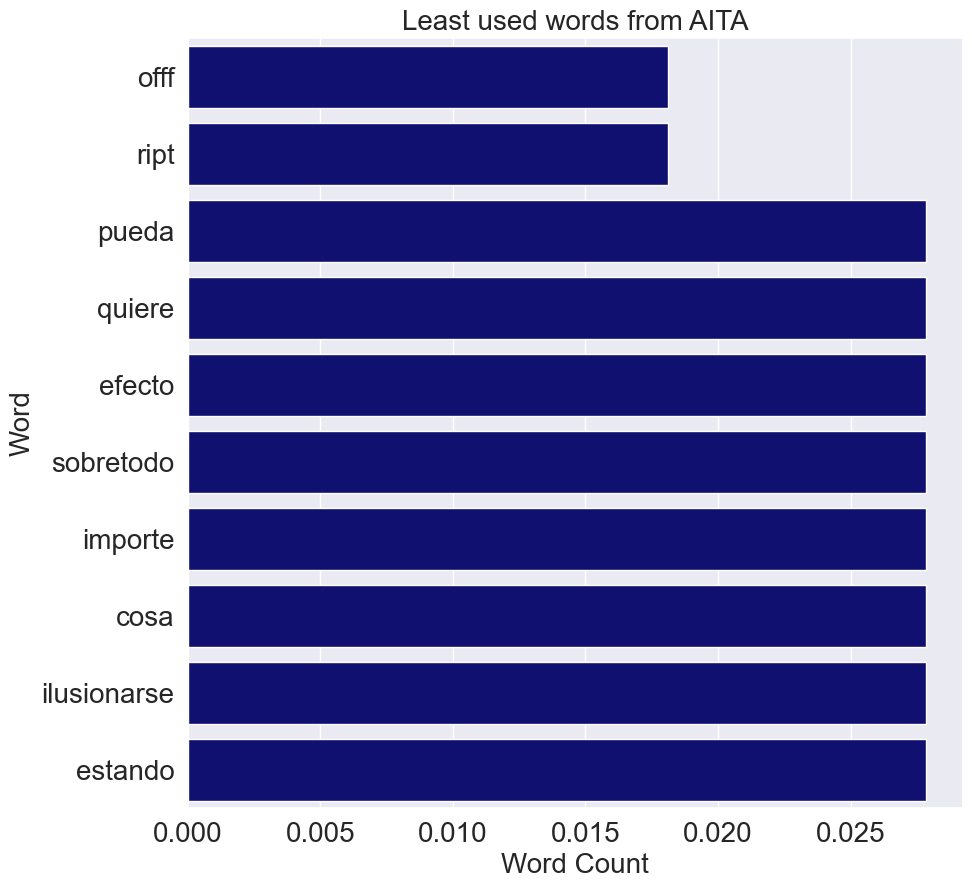

In [560]:
plt.figure(figsize = (10,10))

sns.barplot(data = AITAword_df.sort_values(by = 'count', ascending=True)[:10], 
            y = 'word', 
            x = 'count',
            color = "Navy")

plt.title("Least used words from AITA", fontsize=20)
plt.xlabel('Word Count', fontsize=20);
plt.ylabel('Word', fontsize=20);
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

The language used in both subreddits is similar but AITA has a significatly higher useage ratio comparted to TOMC. 

In [561]:
reddit['text_length'][(reddit["SUB_RED_IT"] == 'AmItheAsshole')].mean(), reddit['text_length'][(reddit["SUB_RED_IT"] == 'TrueOffMyChest')].mean()
# Average post length

(1724.8722386853449, 1630.6508147165082)

This may be a key identifier to how the model predicts which subreddit a post belongs to. Let's check to see if these terms bear significant weight. 

In [562]:
tfidf = TfidfVectorizer(ngram_range=(1,1), stop_words='english')
logreg = LogisticRegression(C = 10, fit_intercept=True, penalty='l2', max_iter=100)

In [563]:
top_10_words = words_df.sort_values(by = 'count', ascending=False)[:10]
top_10_words = top_10_words['word'].to_list()

In [564]:
top_10_words #sanity check

['im', 'just', 'like', 'dont', 'know', 'said', 'feel', 'told', 'time', 'want']

In [565]:
reddit['filtered'] = reddit['alltext'].str.replace("|".join(top_10_words),'', regex=True)

In [566]:
X = reddit['filtered']
y = reddit['SUB_RED_IT']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [567]:
tfidf.fit(X_train)
Xx_train = tfidf.transform(X_train)
Xx_test = tfidf.transform(X_test)

In [568]:
logreg.fit(Xx_train, y_train)

LogisticRegression(C=10)

In [569]:
logreg.score(Xx_train, y_train), logreg.score(Xx_test, y_test)

(0.9751267129716539, 0.8707588342953682)

Similar train score, slightly poorer test score. The prior model works slightly better, albeit not by much. Since the test score did go down, there is value in keeping the top 10 most used words in the model, ergo I will use the prior model.

## Lemmatization

In [570]:
class LemmaTokenizer(): # code from L21
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    
    def __call__(self, document):
        return [self.wnl.lemmatize(word) for word in word_tokenize(document)]

In [571]:
# tfidf = TfidfVectorizer(ngram_range=(1,1), stop_words='english')
# logreg = LogisticRegression(C = 10, fit_intercept=True, penalty='l2', max_iter=100) # for reference

vect_lemmas = TfidfVectorizer(stop_words='english', tokenizer = LemmaTokenizer())
XL_train = vect_lemmas.fit_transform(X_train)
XL_test = vect_lemmas.transform(X_test)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn(


In [572]:
lemmas_df = pd.DataFrame(XL_train.A, columns = vect_lemmas.get_feature_names_out())
lemmas_df.shape

(21308, 48982)

In [573]:
logreg.fit(XL_train, y_train)

logreg.score(XL_train, y_train), logreg.score(XL_test, y_test)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


(0.9702928477567111, 0.8670984091229058)

The score to beat was 97.629% train and , 87.357% test. These scores are fairly identical but in the name of keeping context, I'll use the tfidf+logistic regression model prior. They performed equally well but in this case I believe the TFIDF+Logreg model is more appropriate. 

**Note**: Spacy lemmatization was attempted but exceeded more than 30 minutes of execution time. I decided to end the kernal and not pursue that route.